# Hello Model pretrained XCeption Transfer Learning

Perform transfer learning with pretrained XCeption Model

In [14]:
# Prerequisites
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Get Data

In [2]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

dataset_size = info.splits["train"].num_examples
print("Flower Dataset size: ", dataset_size)
nr_classes = info.features["label"].num_classes
print("Number of classes: ", nr_classes)
class_names = info.features["label"].names
print("Class names: ", class_names)


Flower Dataset size:  3670
Number of classes:  5
Class names:  ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


### Split into train, validation, and test sets

In [3]:
X_test_raw, X_val_raw, X_train_raw = tfds.load("tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"], as_supervised=True)

### Display first images

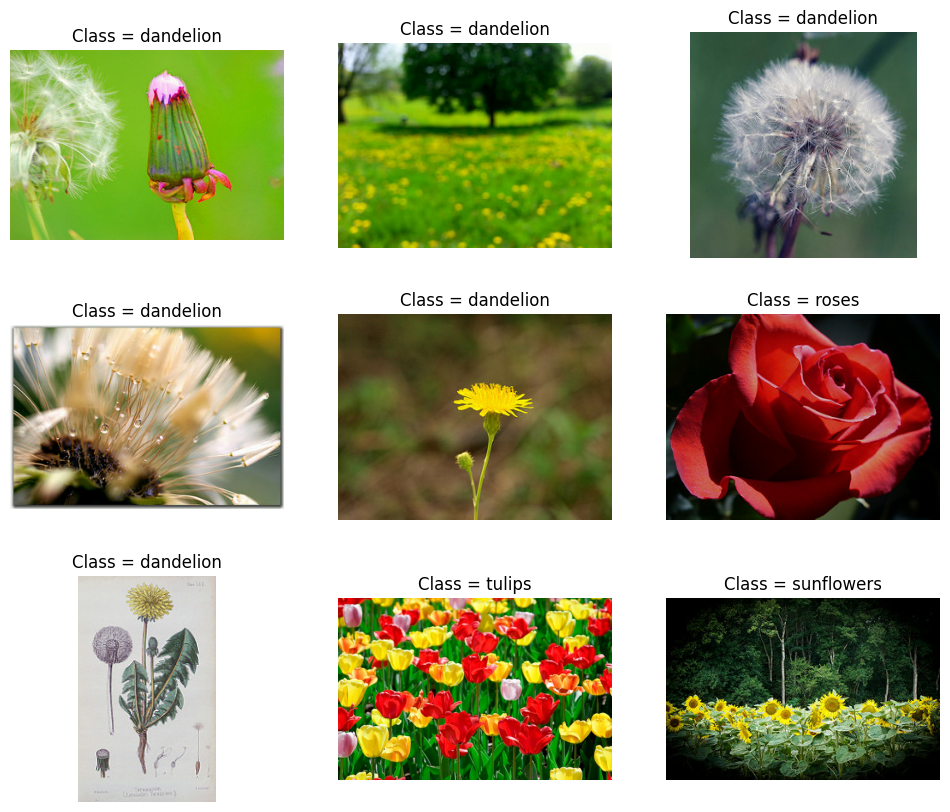

In [10]:
plt.figure(figsize=(12,10))
idx = 0
for image, label in X_val_raw.take(9):
    idx += 1
    plt.subplot(3, 3, idx)
    plt.imshow(image)
    plt.title(f"Class = {class_names[label]}")
    plt.axis("off")

plt.show()

### Resize and batch images

In [7]:
batch_size = 32
preprocess = keras.Sequential([
    keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    keras.layers.Lambda(keras.applications.xception.preprocess_input)
])
X_train = X_train_raw.map(lambda X, y: (preprocess(X), y))
X_train = X_train.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
X_val = X_val_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
X_test = X_test_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

### Create Data Augmentation Layer

In [12]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip(mode="horizontal", seed=42),
    keras.layers.RandomRotation(factor=0.05, seed=42)
])

### Display first imaged sith Augmentation

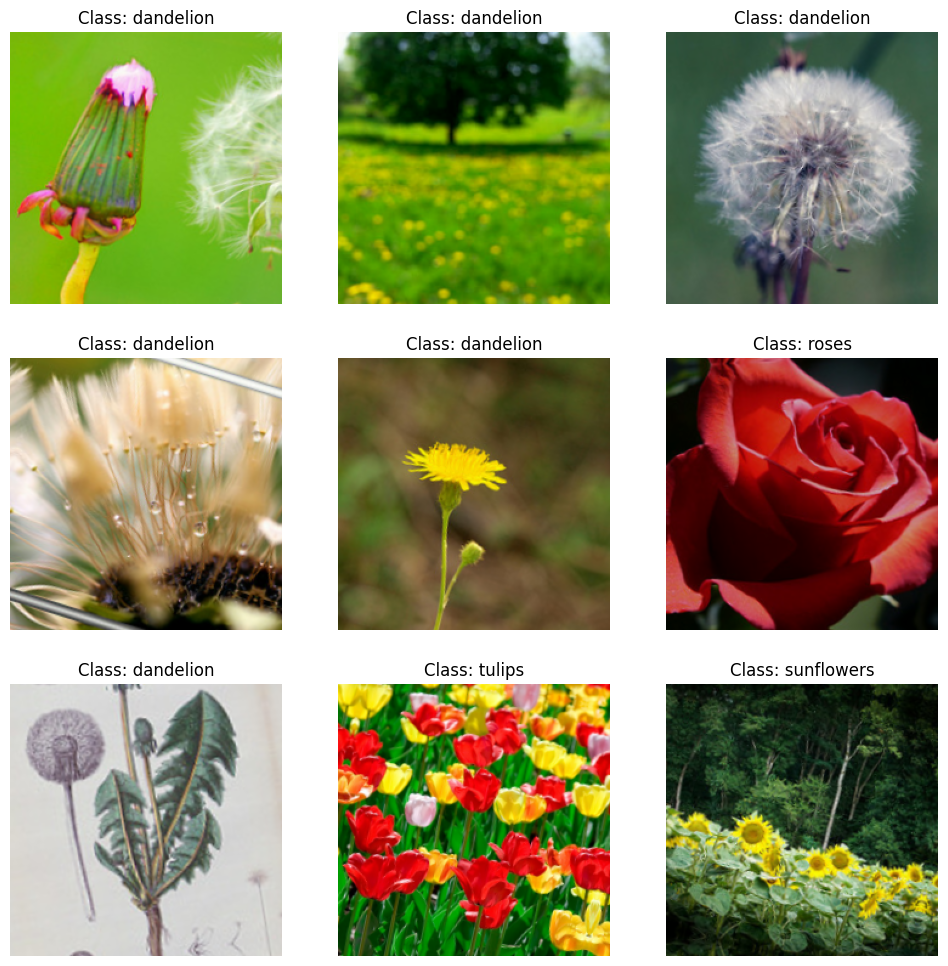

In [13]:

plt.figure(figsize=(12, 12))
for X_batch, y_batch in X_val.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # Rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

### Load Pretrained Model

In [15]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(nr_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


### Freeze layers, train the model for a few epochs

In [16]:
for layer in base_model.layers:
    layer.trainable = False

In [17]:
optimizer = keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train, validation_data=X_val, epochs=3)

Epoch 1/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 88s 995ms/step - accuracy: 0.7278 - loss: 0.8788 - val_accuracy: 0.8403 - val_loss: 0.6677
Epoch 2/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 86s 994ms/step - accuracy: 0.8907 - loss: 0.4312 - val_accuracy: 0.8730 - val_loss: 0.5708
Epoch 3/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 85s 984ms/step - accuracy: 0.9546 - loss: 0.1625 - val_accuracy: 0.8639 - val_loss: 0.6515


Training 3 epochs on DevManPro CPU took 4m 18s

### Unfreeze top layers in base model and train more

In [ ]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train, validation_data=X_val, epochs=12)